# DONNÉES SYNTHÉTIQUES - CAS1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from dolfin import *
import random
set_log_level(LogLevel.ERROR)

[debian:09863] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


In [ ]:
def GenerateSamples(grid_size, sample_size, filename, l_range=[0.2], sigma_range=[0.5]): 
    """ Longueur de corrélation (ℓ)
        Petit ℓ (Ex: 0.05) ==> Variations rapides de κ, Champ très hétérogène.
        Grand ℓ (Ex: 0.5, 1.0) ==> Variations lentes de κ, Champ lisse.

        sigma: Contrôle la magnitude des fluctuations du champ gaussien
        sigma Petit (Ex: 0.1)	==> Faibles variations autour de 0 et κ proche de 1
        sigma Grand (Ex: 1.0)	==> Fortes variations autour de 0 et κ très contrasté """
    
    grid_size = grid_size
    N_SAMPLE = sample_size

    # Meshing 
    x = np.linspace(0, 1, grid_size)
    y = np.linspace(0, 1, grid_size)
    X, Y = np.meshgrid(x, y)
    points = np.column_stack([X.ravel(), Y.ravel()])

    # Maillage FEniCS
    mesh = UnitSquareMesh(grid_size - 1, grid_size - 1)
    V = FunctionSpace(mesh, 'P', 1)
    u = TrialFunction(V)
    v = TestFunction(V)
    f_expr = Expression("100*exp(-100*pow(x[0]-0.5,2) - 100*pow(x[1]-0.5,2))", degree=2)
    f = interpolate(f_expr, V)
    
    def boundary_Dirichlet(x, on_boundary):
        return on_boundary and (near(x[0], 0.0) or near(x[0], 1.0))
    bc = DirichletBC(V, Constant(0.0), boundary_Dirichlet)

    # Récupération des coordonnées des DoFs
    coords_dofs = V.tabulate_dof_coordinates()
    coords_dofs = coords_dofs.reshape((V.dim(), -1))  # (N, 2)

    # Tri des DoFs dans l'ordre spatial
    sorted_idx = np.lexsort((coords_dofs[:, 0], coords_dofs[:, 1]))

    # Préparation du stockage
    total_samples = len(l_range) * len(sigma_range) * N_SAMPLE
    kappa_dataset = np.zeros((total_samples, grid_size, grid_size))
    solution_dataset = np.zeros((total_samples, grid_size, grid_size))

    sample_id = 0  # index global

    for length_scale in l_range:
        for sigma in sigma_range:
            kernel = sigma**2 * RBF(length_scale=length_scale)
            gp = GaussianProcessRegressor(kernel=kernel, optimizer=None, alpha=1e-6)

            # Échantillons GP
            eps_batch = gp.sample_y(points, n_samples=N_SAMPLE, random_state=sample_id)
            eps_batch = eps_batch.reshape(N_SAMPLE, grid_size, grid_size)

            for i in range(N_SAMPLE):
                eps_sample = eps_batch[i]
                kappa_sample = np.exp(eps_sample)
                kappa_dataset[sample_id] = kappa_sample

                # Interpolation sur les DoFs (ordre trié)
                kappa_vals = kappa_sample.flatten()[sorted_idx]
                kappa_function = Function(V)
                kappa_function.vector()[:] = kappa_vals

                # Résolution variationnelle
                a = inner(kappa_function * grad(u), grad(v)) * dx
                L = f * v * dx
                u_sol = Function(V)
                solve(a == L, u_sol, bc)
                
                # Sauvegarde discrète sur grille régulière
                u_grid = np.array([u_sol(Point(p)) for p in points]).reshape(grid_size, grid_size)
                solution_dataset[sample_id] = u_grid

                sample_id += 1

    print(f"Total samples: {sample_id}")

    # Sauvegarde .npz des versions discrètes
    fileout = filename+".npz"
    np.savez(fileout, kappa=kappa_dataset, u=solution_dataset)
    print(f"Solutions sauvegarder dans le fichier {filename}.npz")
    return

# ================================================================================

# Visualisation d'un échantillon aléatoire 
def View_Sample(filename):
    """Visualize a random sample"""
    file = filename+".npz"
    data = np.load(file)
    kappa = data["kappa"]
    u = data["u"]

    i = random.randint(0, len(kappa)-1)

    # Create figure and axes manually
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Image 1
    plt.subplot(1, 2, 1)
    im0 = axs[0].imshow(kappa[i], origin="lower", cmap="rainbow")
    axs[0].set_title(f"k(x,y) – Sample #{i+1}")
    fig.colorbar(im0, ax=axs[0])

    # Image 2
    plt.subplot(1, 2, 2)  
    im1 = axs[1 ].imshow(u[i], origin="lower", cmap="jet")
    axs[1].set_title(f"u(x,y)")
    fig.colorbar(im1, ax=axs[1], label="Amplitude")
    
    plt.tight_layout()
    plt.show()
    return

In [ ]:
low_res = 32 # Low resolution grid 
GenerateSamples(grid_size=low_res, sample_size=512, filename="Train",
                l_range = [0.05, 0.1, 0.2, 0.5], sigma_range = [0.1, 0.5, 1.0])

# Visualisation d'un échantillon
View_Sample(filename="Train")

## Echantillons de test
### Cas N°1: Perméabilité connue - Test de Super-Résolution 
<strong>Paramètres :</strong> ℓ = 0.05, 0.1, 0.2, 0.5, sigma = 0.1, 0.5, 1.0, grid_size=256  

Total samples: 768
Solutions sauvegarder dans le fichier Test_1.npz


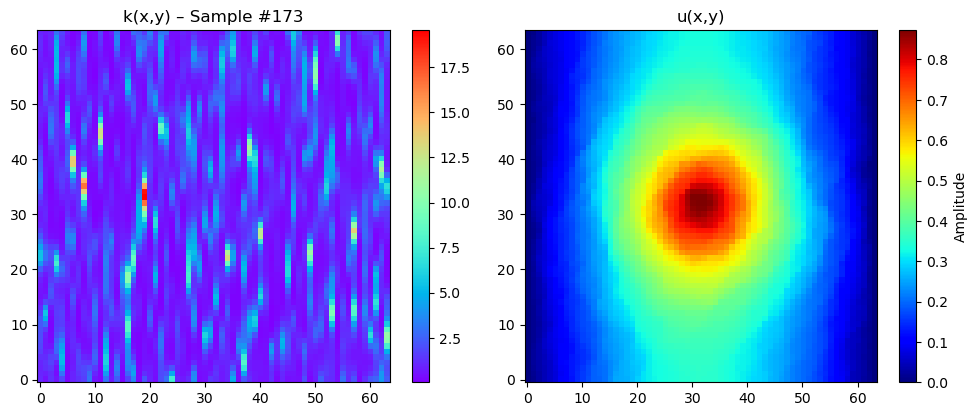

In [ ]:
high_res = 64 # High resolution grid 
GenerateSamples(grid_size=high_res, sample_size=64, filename="Test_1", l_range = [0.05, 0.1, 0.2, 0.5], sigma_range = [0.1, 0.5, 1.0])
View_Sample(filename="Test_1")

### Cas N°2: Perméabilité inconnue 
<strong>Paramètres :</strong> <br> ℓ=0.3, 0.4, 0.6, 0.7 sigma = 0.3, 0.7 

Total samples: 512
Solutions sauvegarder dans le fichier Test_2.npz


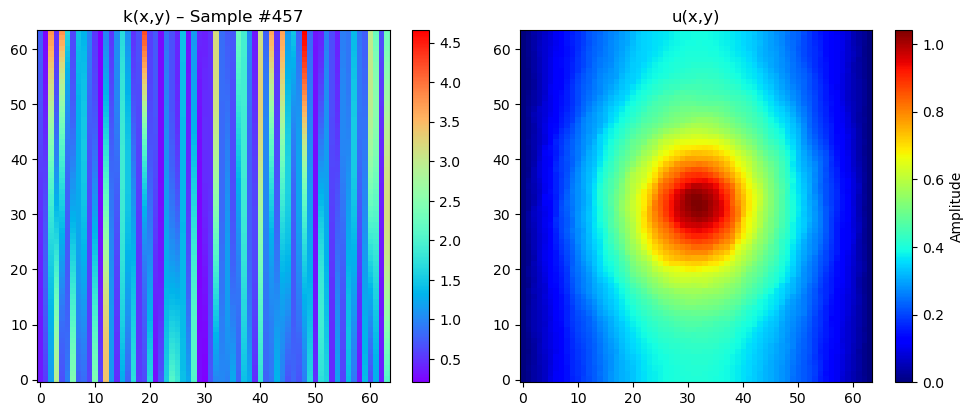

In [ ]:
GenerateSamples(grid_size=high_res, sample_size=64, filename="Test_2", l_range = [0.3, 0.4, 0.6, 0.7], sigma_range = [0.3, 0.7])
View_Sample(filename="Test_2")